# UNDERSTANDING SENTIMENTS IN EPINIONS

In this project, we are analysing customer reviews for Fuji Digital Camera obtained from Epinions data.com. Given data consists 50% of the reviews about Digital Cameras and remining 50% is about Automobiles.

For every record, we are considering the review "TEXT" and "Label" value after where “Yes” means that a consumer recommends that product and “No” denotes the opposite.

We split the data into two parts: Train and Test and identify the best classification model. We then validate the performance of this model on Automobile data.


## Libraries

In [442]:
# Load required libraries 

import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords
import string
from string import digits
import re
import sklearn
from collections import Counter
from bs4 import BeautifulSoup
import codecs

In [330]:
# Libraries & parameters used for plotting

%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
colors = ['cobalt', 'orangey yellow', 'steel grey', 'tomato', 'dark lilac', 'bluish green']
cmap = sns.xkcd_palette(colors)
import matplotlib.pyplot as plt

## Data Loading

In [2]:
# Set path of the epinions file
filepath = os.path.join('..\Datasets\D1.txt')

In [444]:
# Load data from file
with open(filepath) as myfile:
    data = myfile.read()

In [4]:
# Using BeautifulSoup to parse the data
soup = BeautifulSoup(data, 'lxml')

In [5]:
print type(soup)

<class 'bs4.BeautifulSoup'>


In [6]:
print soup.prettify()[:199]

<html>
 <body>
  <doc>
   <docid>
    36
   </docid>
   <product>
    Digital_Cameras/Casio_QV_4000_4_0_Megapixel_Digital_Camera_EX_Plus_Outfit__Camera_QV4000EXK
   </product>
   <label>
    Yes
    


In [7]:
# Split all the documents in the file
documents = soup.find_all('doc')

In [8]:
# Total number of documents
len(documents)

12000

In [11]:
# Add the data to pandas dataframe
tab = pd.DataFrame()

for idx, doc in enumerate(documents):
    tab.loc[idx,'DOCID'] = str(doc.docid.contents[0]).strip('\n').strip(' ')
    tab.loc[idx,'PRODUCT'] =  str(doc.product.contents[0]).strip('\n').strip(' ')
    tab.loc[idx,'LABEL'] =  str(doc.label.contents[0]).strip('\n').strip(' ')
    tab.loc[idx,'RATING'] =  str(doc.rating.contents[0]).strip('\n').strip(' ')
    tab.loc[idx,'URL'] =  str(doc.url.contents[0]).strip('\n').strip(' ')
    tab.loc[idx,'CLASS'] =  str(doc.find('class').contents[0]).strip('\n').strip(' ')
    tab.loc[idx,'TEXT'] =  doc.find('text').contents[0].strip('\n').strip(' ')

In [12]:
tab.tail()

,DOCID,PRODUCT,LABEL,RATING,URL,CLASS,TEXT
11995,36432,auto_Make/auto_Make-1994_Ford_Probe,Yes,5.0,http://www.epinions.com/content_110045859460,Auto,"I just traded-in my Ford Probe GT, auto. Coupe..."
11996,36437,auto_Make/auto_Make-1987_Dodge_Diplomat,Yes,5.0,http://www.epinions.com/content_38862753412,Auto,In my younger days .driving a cool car was a ...
11997,36442,auto_Make/auto_Make-2002_Nissan_Altima,Yes,4.0,http://www.epinions.com/content_46086590084,Auto,"I bought the 2.5S w/floor mats, in-cabin micro..."
11998,36447,auto_Make/auto_Make-2002_Nissan_Altima,Yes,5.0,http://www.epinions.com/content_63460839044,Auto,I got this car about two weeks ago. I have the...
11999,36452,auto_Make/auto_Make-2002_Nissan_Altima,No,4.0,http://www.epinions.com/content_88014163588,Auto,"The contestants:\n2003 Mazda 6s, 5-Speed Manua..."


### Split the data by the Class

In [305]:
# Split the data into two dataframes by CLASS

auto = (tab[tab.CLASS == 'Auto'])
camera = (tab[tab.CLASS == 'Camera'])

## Visual Analysis of Data

### Distribution of data for consumer recommending a product from Class = [Auto, Camera]

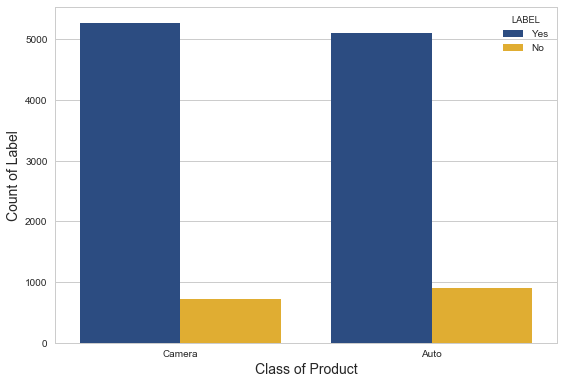

In [338]:
sns.countplot(x="CLASS", hue = "LABEL", data=tab, palette=cmap)
plt.ylabel('Count of Label', fontsize=14)
plt.xlabel('Class of Product', fontsize=14)
plt.tight_layout()

### Distribution of data for consumer ratings of products from Class = [Auto, Camera]

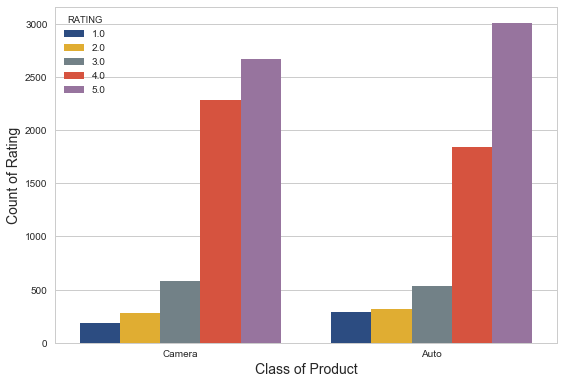

In [337]:
sns.countplot(x="CLASS", hue = "RATING", data=tab, palette = cmap)
sns.color_palette('colorblind', n_colors=8)
plt.ylabel('Count of Rating', fontsize=14)
plt.xlabel('Class of Product', fontsize=14)
plt.tight_layout()

### Distribution of data for consumer ratings for Camera vs if the recommend the product or not.

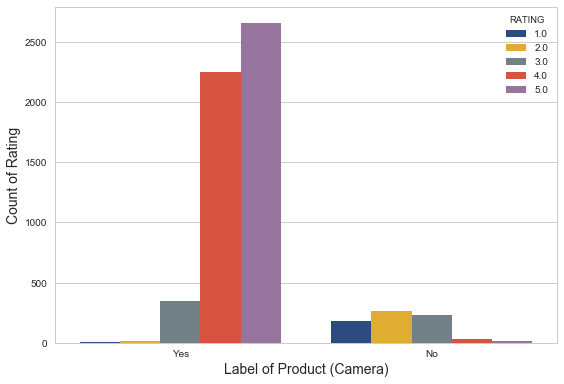

In [340]:
sns.countplot(x="LABEL", hue = "RATING", data=camera, palette = cmap)
plt.ylabel('Count of Rating', fontsize=14)
plt.xlabel('Label of Product (Camera)', fontsize=14)
plt.tight_layout()

## Data Pre-processing

We will clean up the text of reviews using regex and functions offered by nltk package.

The following function processes and tokenizes raw text. We use nltk package to tokenize and clean the text. This includes removing numbers, stopwords, punctuations, converting the text to lower case and lemmatizing.

In [251]:
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """
    input:
        text: string of one review
        lemmatizer: default is nltk.stem.wordnet.WordNetLemmatizer()
    output:
        result: list of tokenized words
    """
    
    tokenized = []
    lemmatized = []
    
    # Remove numbers
    text = re.sub('\d', ' ', text)
    
    # Normalizes case
    text = text.lower()
    
#     remove bad characters
#     text = re.sub(r'[\x92]', " ",text)
    
    # remove apostrophes, delete 's
    text = text.replace('\'s', '')
    text = text.replace('\'', ' ')
    
    # Remove punctuations  
    for char in string.punctuation:
        text = text.replace(char, ' ')
        
    # Tokenize text
    tokenized = nltk.word_tokenize(text)
    
    for word in tokenized:
        # Remove stopwords
        if word not in stopwords.words('english'):
            try:
                # lemmatize word
                lemmatized.append(lemmatizer.lemmatize(word))
            except Exception:
                pass
    return ' '.join(word for word in lemmatized)

In [252]:
# Example

text = "This is a sample test input for 's processing loves."
print process(text)

sample test input processing love


The following function makes use of the process() function that we defined earlier to clean all the text in the last column of pandas dataframe. Here, we assume the last column has all the reviews.

In [253]:
def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """
    Inputs
        df: pd.DataFrame: dataframe containing a column 'text' in last column
        lemmatizer: the default argument is of type nltk.stem.wordnet.WordNetLemmatizer
    Outputs
        pd.DataFrame: dataframe in which the values of text column have been changed from str to list(str),
                        the output from process_text() function. Other columns are unaffected.
    """
    df_copy = df.copy()
    df_length = len(df_copy.iloc[:,-1])
        
    temp = [process(df_copy.iloc[i,-1]) for i in range(df_length)]  
    df_copy.loc[:,'TEXT'] = temp
    
    return df_copy

### Performing data cleaning for Camera reviews

In [345]:
# BEFORE 
camera.TEXT[2][:100]

u'Ah, finally, A great little camera for the beginner at an easy to swallow price.\n\nThis is one of man'

In [265]:
processed = process_all(camera)

In [342]:
# AFTER
processed.TEXT[2][:100]

u'ah finally great little camera beginner easy swallow price one many digital camera series reviewing '

### Performing data cleaning for Automobile reviews

In [271]:
processed_auto = process_all(auto)

In [341]:
processed_auto.TEXT[6002][:100]

u'im car snob like driving foreign car little trepidation actually agreed take gasp taurus rental car '

In [423]:
processed.head()

,DOCID,PRODUCT,LABEL,RATING,URL,CLASS,TEXT
0,36,Digital_Cameras/Casio_QV_4000_4_0_Megapixel_Di...,Yes,5.0,http://www.epinions.com/content_66677280388,Camera,stumbled upon camera much research hard unders...
1,107,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,Yes,4.0,http://www.epinions.com/elec-review-31F6-E9DA6...,Camera,note japanese version camera difference though...
2,108,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,Yes,4.0,http://www.epinions.com/elec-review-B67-D4F9A3...,Camera,ah finally great little camera beginner easy s...
3,109,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,Yes,5.0,http://www.epinions.com/elec-review-7463-6CD18...,Camera,okay ive written three negative review row tim...
4,110,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,No,2.0,http://www.epinions.com/elec-review-2E51-6E04C...,Camera,camera great deal wal mart right going fast ab...


### Split data into Training and Testing set

Here we split the data into train (70%) and test (30%) set.

In [267]:
n = int(0.7 * len(processed))
train = processed.TEXT[:n]
test = processed.TEXT[n: ]
train_label = processed.LABEL[:n]
test_label = processed.LABEL[n:]

In [391]:
train.head()

0    stumbled upon camera much research hard unders...
1    note japanese version camera difference though...
2    ah finally great little camera beginner easy s...
3    okay ive written three negative review row tim...
4    camera great deal wal mart right going fast ab...
Name: TEXT, dtype: object

In [392]:
train_label.head()

0    Yes
1    Yes
2    Yes
3    Yes
4     No
Name: LABEL, dtype: object

## Feature Construction

Our goal here is to derive feature vectors from the processed reviews. In this section, we are constructing a bag-of-words TF-IDF feature vector.

In [389]:
# Calculate the total number of words
words = []
[words.extend(nltk.word_tokenize(processed.loc[i,'TEXT'])) for i in range(len(processed.loc[:,'TEXT']))]
len(words)

1174852

Since the number of possible words is large and not all of them may be useful for our classification task. We first determine which words to retain, and which to omit. Since we have already pruned the stopwords, we will now prune words that are used rarely and usually tend to be typos. We consider a word rare if it occurs not more than once.

The below function use the word count information across all reviews in data to come up with a feature list.

In [424]:
def get_rare_words(processed_data):
    """ 
    Inputs:
        processed_data: pd.DataFrame: the output of process_all() function
    Outputs:
        list(str): list of rare words, sorted alphabetically.
    """
    c = []
    [c.extend(nltk.word_tokenize(processed_data.loc[i,'TEXT'])) for i in range(len(processed_data.loc[:,'TEXT']))]
    k = Counter(c)
    words = (Counter(el for el in k.elements() if k[el] < 5))
    wordlist = list(words.elements())
    return sorted(wordlist)

In [425]:
rare_words = get_rare_words(processed)

In [426]:
len(rare_words)

21850

In [414]:
print rare_words[:20]

[u'aaaa', u'aaaaaaahhhh', u'aaaah', u'aaaalkaline', u'aaahs', u'aaarrrgghhh', u'aahs', u'aan', u'aashook', u'aax', u'aaxes', u'aback', u'abaco', u'abb', u'abberration', u'abbreviated', u'abc', u'abel', u'aberratons', u'abesofmaine']


We now construct a sparse matrix of features for each review with the help of sklearn.feature_extraction.text.TfidfVectorizer.

In [429]:
# the TfidfVectorizer object used
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(rare_words)
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = stopwords)

# sparse bag-of-words TF-IDF feature matrix
X = vectorizer.fit_transform(processed.TEXT)

# transform the test data 
y = vectorizer.transform(test)

In [432]:
X.get_shape()

(6000, 7271)

## Classification

In this section, we put try to larn a model to classify the opinions. We will be using two classifiers: Support Vector Machines and Naive Bayes Classifier. We will then score the clssifier based on how well it performs against test data and use it for predicting sentiments from opinions.

Although there are several metrics available (e.g., accuracy, precision, recall, etc), we will go with accuracy and determine how accurately our model is able to classify opinions.

### SVM Classifier

In [398]:
from sklearn import svm

# Train both classifiers
for kernel in ['rbf', 'linear', 'sigmoid', 'poly']:
    for C in [1e2, 1e3, 1e4, 1e5]:
        clf_svm = svm.SVC(kernel=kernel, C=C)
        clf_svm.fit(X, train_label)
        print kernel, C, clf_svm.score(y, list(test_label))

rbf 100.0 0.852777777778
rbf 1000.0 0.852777777778
rbf 10000.0 0.887777777778
rbf 100000.0 0.869444444444
linear 100.0 0.869444444444
linear 1000.0 0.869444444444
linear 10000.0 0.869444444444
linear 100000.0 0.869444444444
sigmoid 100.0 0.852777777778
sigmoid 1000.0 0.852777777778
sigmoid 10000.0 0.868333333333
sigmoid 100000.0 0.873333333333
poly 100.0 0.852777777778
poly 1000.0 0.852777777778
poly 10000.0 0.852777777778
poly 100000.0 0.852777777778


Based on the above results, the best kernel type is rbf and the best C is 1e4.

### Naive Bayes Classifier

In [269]:
from sklearn.naive_bayes import MultinomialNB
X = vectorizer.transform(train)
X_dev = vectorizer.transform(test)
clf_nb = MultinomialNB()
clf_nb.fit(X, train_label)
clf_nb.score(X_dev, list(test_label))

0.85277777777777775

From the above results, we can conclude that SVM (kernel==rbf and C==1e4) performs better than Naive Bayes Classifier. Thus, we will trin the classifier with the optimum parameters.

In [416]:
X = vectorizer.fit_transform(processed.TEXT)
clf_svm = svm.SVC(kernel = 'rbf', C = 1e4)
clf_svm.fit(X, processed.LABEL)
y = vectorizer.transform(processed.TEXT)
clf_svm.score(y, list(processed.LABEL))

0.97283333333333333

Validating the performance of the model parameters on Automobiles data:

In [417]:
X = vectorizer.fit_transform(processed_auto.TEXT)
clf_svm = svm.SVC(kernel = 'rbf', C = 1e4)
clf_svm.fit(X, processed_auto.LABEL)
y = vectorizer.transform(processed_auto.TEXT)
clf_svm.score(y, list(processed_auto.LABEL))

0.94733333333333336

In [420]:
indices = np.argsort(vectorizer.idf_)[::-1]
features = vectorizer.get_feature_names()
top_n = 100
top_features = [features[i] for i in indices[:top_n]]
print top_features

[u'zowie', u'harmless', u'handicam', u'handiwork', u'handstrap', u'handwriting', u'handycam', u'hardwarestreet', u'harping', u'handgun', u'hasty', u'srgb', u'srelectronics', u'haunting', u'haveing', u'squeal', u'stall', u'hampshire', u'squarely', u'starlight', u'statestreetdirect', u'statendam', u'greasy', u'startling', u'grind', u'groom', u'grouped', u'hah', u'grownup', u'grrrr', u'stanford', u'gto', u'guideline', u'gush', u'hazard', u'headstone', u'discreet', u'holographic', u'hired', u'splotch', u'hitachi', u'ho', u'splatter', u'splashed', u'spiritual', u'himalaya', u'honduras', u'spill', u'spiffy', u'honored', u'hoodman', u'spherical', u'hire', u'hight', u'health', u'spotting', u'heartache', u'heated', u'heating', u'sprouting', u'heckuva', u'hehehe', u'helm', u'spontaneously', u'henry', u'herd', u'hesitates', u'hewlet', u'hg', u'highend', u'grayscales', u'stationery', u'grant', u'futureshop', u'funflash', u'furby', u'furry', u'furthest', u'stowed', u'stove', u'gag', u'fuchsia', u's

In [421]:
vectorizer.get_feature_names()

[u'aa',
 u'aaa',
 u'aac',
 u'ab',
 u'abandon',
 u'abandoned',
 u'abberation',
 u'abberations',
 u'abbreviation',
 u'aberration',
 u'ability',
 u'abit',
 u'able',
 u'ablility',
 u'abnormally',
 u'aboard',
 u'abort',
 u'abound',
 u'abreast',
 u'abroad',
 u'absence',
 u'absent',
 u'absolute',
 u'absolutely',
 u'absolutley',
 u'absolutly',
 u'abstract',
 u'absurd',
 u'absurdly',
 u'abundance',
 u'abundant',
 u'abuse',
 u'abused',
 u'abut',
 u'abysmal',
 u'ac',
 u'academic',
 u'acc',
 u'accent',
 u'accept',
 u'acceptable',
 u'acceptably',
 u'acceptance',
 u'accepted',
 u'accepting',
 u'accepts',
 u'accesible',
 u'accesories',
 u'accesory',
 u'access',
 u'accessable',
 u'accessed',
 u'accessibility',
 u'accessible',
 u'accessing',
 u'accessory',
 u'accident',
 u'accidental',
 u'accidentally',
 u'accidently',
 u'acclaim',
 u'acclaimed',
 u'accolade',
 u'accomidate',
 u'accommodate',
 u'accommodates',
 u'accomodate',
 u'accomodates',
 u'accompanied',
 u'accompanies',
 u'accompany',
 u'accompan

In [422]:
vectorizer.

array([ 2.90853135,  5.49293027,  8.64993069, ...,  4.77872968,
        7.95678351,  8.64993069])